## What is joblib?
joblib is a python module which includes functionality for doing various useful tasks, like caching the output of functions given certain input, logging/tracing, and easy parallelization.  Today, we'll focus on the latter, which essentially is a wrapper around Python's built-in `multiprocessing` module.  It's essentially just an extremely easy way to write a parallelized `for` loop.

## joblib.Parallel and joblib.delayed
Two write a simple parallelized `for` loop using joblib, you need to use the `Parallel` class and the `delayed` function.  Together, they form a construct which looks a lot like list comprehension.  `delayed` is a [decorator](http://nbviewer.ipython.org/github/craffel/crucialpython/blob/master/week7/decorators.ipynbdecorator) which simply returns the function, its arguments, and its keyword arguments as a tuple.  `Parallel` constructs a class which can be called with a list of tuples, where each tuple includes a function and its arguments.  It subsequently calls each function from each tuple with the corresponding arguments.  But, what you really need to know in practice is simple:

In [2]:
from joblib import Parallel, delayed
import numpy as np
print [np.power(i, 2) for i in xrange(10)]
print Parallel()(delayed(np.power)(i, 2) for i in xrange(10))

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]


In [3]:
# To parallelize, simply set the n_jobs argument!
Parallel(n_jobs=8)(delayed(np.power)(i, 2) for i in xrange(10))

[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]

## Practical example
`np.power` is not a function you'd need to parallelize calls to in general, because it's so fast and the overhead for parallelization makes it not worth while (we'll get to that later).  Here's a function which actually takes a while to compute:

In [4]:
def convolve_random(size):
    ''' Convolve two random arrays of length "size" '''
    return np.convolve(np.random.random_sample(size), np.random.random_sample(size))

In [5]:
# Time to run once with length-40000 arrays
%timeit convolve_random(40000)

1 loops, best of 3: 904 ms per loop


In [6]:
# Time to run sequentially for length 40000, 41000, 42000, ... 47000 arrays
%timeit [convolve_random(40000 + i*1000) for i in xrange(8)]
# In parallel, with 8 jobs
%timeit Parallel(n_jobs=8)(delayed(convolve_random)(40000 + i*1000) for i in xrange(8))

1 loops, best of 3: 8.69 s per loop
1 loops, best of 3: 2.88 s per loop


## Other useful features of Parallel
The `Parallel` class is meant to be more convenient to use than `multiprocessing`.  As such, it can dump out progress messages, cleanly report errors, and be interrupted with ctrl-C, all of which takes some effort to do in `multiprocessing`.

In [7]:
# Use the verbose argument to display progress messages.
# The frequency of the messages increases with the verbosity level. 
result = Parallel(n_jobs=8, verbose=50)(delayed(convolve_random)(40000 + i*1000) for i in xrange(16))

[Parallel(n_jobs=8)]: Done   1 out of  16 | elapsed:    2.1s remaining:   32.0s
[Parallel(n_jobs=8)]: Done   2 out of  16 | elapsed:    2.2s remaining:   15.7s
[Parallel(n_jobs=8)]: Done   3 out of  16 | elapsed:    2.4s remaining:   10.3s
[Parallel(n_jobs=8)]: Done   4 out of  16 | elapsed:    2.5s remaining:    7.4s
[Parallel(n_jobs=8)]: Done   5 out of  16 | elapsed:    2.6s remaining:    5.6s
[Parallel(n_jobs=8)]: Done   6 out of  16 | elapsed:    2.7s remaining:    4.5s
[Parallel(n_jobs=8)]: Done   7 out of  16 | elapsed:    2.8s remaining:    3.6s
[Parallel(n_jobs=8)]: Done   8 out of  16 | elapsed:    3.0s remaining:    3.0s
[Parallel(n_jobs=8)]: Done   9 out of  16 | elapsed:    5.3s remaining:    4.1s
[Parallel(n_jobs=8)]: Done  10 out of  16 | elapsed:    5.6s remaining:    3.3s
[Parallel(n_jobs=8)]: Done  11 out of  16 | elapsed:    5.9s remaining:    2.7s
[Parallel(n_jobs=8)]: Done  12 out of  16 | elapsed:    6.0s remaining:    2.0s
[Parallel(n_jobs=8)]: Done  13 out of  1

## When should you use Parallel?
The easiest case (and the only case we'll cover here) is when you want to run the same process many times with different arguments, where each run of the process does not depend on any other runs.  This is the intended use of `joblib.Parallel`.

Furthermore, as mentioned above, there's some overhead to using parallelization in general.  As a simple rule, for very fast functions, it's not worth it, and for very slow functions, you'll get a speedup which levels off as you approach the number of cores you have.  The following code seeks to test this in a principled way using our `convolve_random` function.

In [8]:
# Try convolution sizes [5000, 10000, 15000 ... 50000]
sizes = 5000*(1 + np.arange(10))
# Try n_jobs from [1, ..., max_jobs]
max_jobs = 8
n_jobs_values = 1 + np.arange(max_jobs)

In [ ]:
import time
# Store the timing for each setting
times = np.zeros((n_jobs_values.shape[0], sizes.shape[0]))
for n, n_jobs in enumerate(n_jobs_values):
    for m, size in enumerate(sizes):
        start = time.time()
        result = Parallel(n_jobs=n_jobs)(delayed(convolve_random)(size) for i in xrange(max_jobs))
        # Compute and store elapsed time
        times[n, m] = time.time() - start
# Save it out so we don't have to run it twice
np.savetxt('times.txt', times)

In [9]:
import matplotlib.pyplot as plt
# Load in our pre-computed times
times = np.genfromtxt('times.txt')

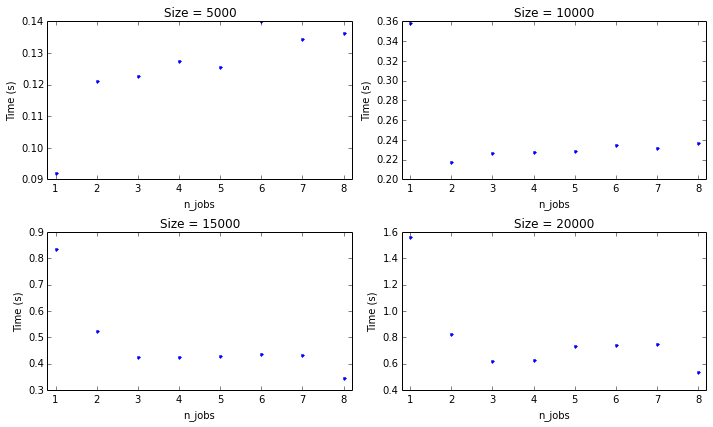

In [10]:
plt.figure(figsize=(10, 6))
for size_index in xrange(4):
    plt.subplot(2, 2, size_index + 1)
    # Plot the times for this size by n_jobs
    plt.plot(n_jobs_values, times[:, size_index], '.')
    # Set up axes and labels
    plt.xticks(n_jobs_values)
    plt.xlim([.8, max_jobs + .2])
    plt.title('Size = {}'.format(sizes[size_index]))
    plt.xlabel('n_jobs')
    plt.ylabel('Time (s)')
plt.tight_layout()

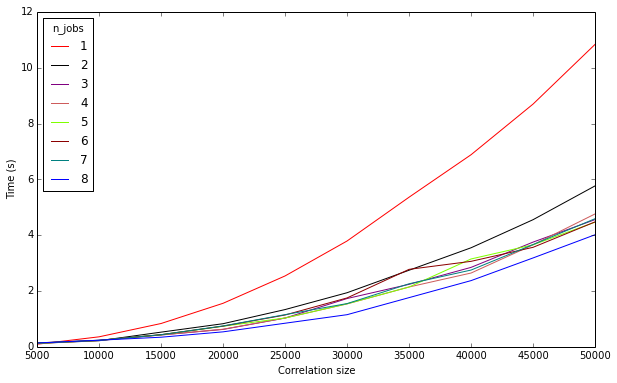

In [11]:
bplt.figure(figsize=(10, 6))
# Need as many colors as max_jobs!
colors = ['r', 'k', 'Purple', 'IndianRed', 'Chartreuse', 'DarkRed',  'Teal', 'b']
ax = plt.gca().set_color_cycle(colors)
# Plot each n_jobs setting as a different line
for job_results in times:
    plt.plot(sizes, job_results)
# Set up labels and legend
plt.xlabel('Convolution size')
plt.ylabel('Time (s)')
plt.legend(n_jobs_values, 'upper left', title='n_jobs')

---

Credits and resources:
- crucialpython: https://github.com/craffel/crucialpython
- https://pythonhosted.org/joblib/